<a href="https://colab.research.google.com/github/hijyun/Machine-Learning/blob/main/ensemble_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고자료
https://bigdaheta.tistory.com/33

Base code는 위스콘신 유방암 예측 모델 코드

Dataset은 와인 데이터셋으로 아래 작성된 예제는 와인의 화학 조성을 사용하여 와인의 종류를 가장 잘 예측하는 모델을 찾는다.

# 기본 패키지 설정

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier # 결정 트리
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀

from sklearn.ensemble import VotingClassifier,RandomForestClassifier,AdaBoostClassifier # 앙상블 

from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score  # ROC곡선 그리기

from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV, cross_val_score  # 하이퍼파라미터 튜닝, 교차타당도

# 데이터 읽기

In [ ]:
df1 = pd.read_csv('https://archive.ics.uci.edu/ml/''machine-learning-databases/wine/wine.data',header=None)
df1.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
              'Alcalinity of ash', 'Magnesium', 'Total phenols',
              'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
              'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
              'Proline']
              
df1 = df1[df1['Class label'] != 1]

y = df1['Class label'].values
print(collections.Counter(y))
X = df1[['Alcohol', 'OD280/OD315 of diluted wines']].values
# 와인의 도수, 희석 와인의 OD280/OD315 비율 feature 만 사용 


Counter({2: 71, 3: 48})


In [ ]:
df1.shape

(119, 14)

In [ ]:
df1.head()

Class label  Alcohol  ...  OD280/OD315 of diluted wines  Proline
59            2    12.37  ...                          1.82      520
60            2    12.33  ...                          1.67      680
61            2    12.64  ...                          1.59      450
62            2    13.67  ...                          2.46      630
63            2    12.37  ...                          2.87      420

[5 rows x 14 columns]

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 59 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Class label                   119 non-null    int64  
 1   Alcohol                       119 non-null    float64
 2   Malic acid                    119 non-null    float64
 3   Ash                           119 non-null    float64
 4   Alcalinity of ash             119 non-null    float64
 5   Magnesium                     119 non-null    int64  
 6   Total phenols                 119 non-null    float64
 7   Flavanoids                    119 non-null    float64
 8   Nonflavanoid phenols          119 non-null    float64
 9   Proanthocyanins               119 non-null    float64
 10  Color intensity               119 non-null    float64
 11  Hue                           119 non-null    float64
 12  OD280/OD315 of diluted wines  119 non-null    float64
 13  Prol

# 전처리 및 데이터 분할

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() # 범주형 변수를 0부터 시작하는 정수형 숫자로 변환
y = le.fit_transform(y)


In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

## train data , test data split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1234, stratify=y)

# 모델

##  voting

logistic(로지스틱 회귀분석), tree(의사결정나무), knn(k-최근접 이웃)에 대한 모델링을 시행한다. 보팅 유형에는 예측한 결괏값 중 다수의 분류기가 결정한 예측값을 최종 보팅 결괏값으로 선정하는 하드 보팅(Hard Voting)과 분류기들의 레이블 값 결정 확률을 모두 더하여 이를 평균 내어 확률 값이 가장 높은 레이블을 최종 보팅 결괏값으로 선정하는 소프트 보팅(Soft Voting)이 있다. (일반적으로소프트 보팅 방법이 적용된다.)


In [ ]:
logistic = LogisticRegression(solver='liblinear',penalty='l2',C=100,random_state=1)
tree = DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=1)
knn = KNeighborsClassifier(n_neighbors=1,p=2,metric='minkowski')

voting_estimators = [('logistic', logistic), ('tree', tree), ('knn', knn)]

voting = VotingClassifier(estimators = voting_estimators,voting='soft')

clf_labels = ['Logistic regression', 'Decision tree', 'KNN', 'Majority voting']

all_clf = [logistic, tree, knn, voting]

### AUC 검정

AUC 결과, 로지스틱 회귀분석은 97.8%, 의사결정 나무는 91%, KNNdms 85.7%, 투표 기법을 사용한 결과는 98%로 Voting 기법을 사용했을 때 모델 성능이 가장 좋다는 것을 알 수 있다.

In [ ]:
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
  % (scores.mean(), scores.std(), label))

ROC AUC: 0.978 (+/- 0.047) [Logistic regression]
ROC AUC: 0.911 (+/- 0.088) [Decision tree]
ROC AUC: 0.857 (+/- 0.109) [KNN]
ROC AUC: 0.980 (+/- 0.046) [Majority voting]


### ROC 커브

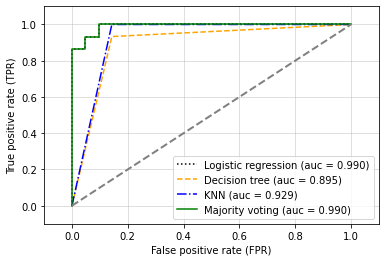

In [ ]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr) # 교차검증 X
  plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.3f)' % (label, roc_auc))
  
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
          linestyle='--',
          color='gray',
          linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

### 정오 분류표로 검정

In [ ]:
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)

print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 3
정확도: 0.917
정밀도: 0.875
재현율: 0.933
F1: 0.903


### 오답 확인

참고 <알콜 평균>
- 라벨 0  :  12.27
- 라벨 1  :  13.15

     <희석비율 평균>
- 라벨 0 : 2.7
- 라벨 1 : 1.68

In [ ]:
test = pd.DataFrame(np.column_stack([X_test,y_test]), columns=['Alcohol', '희석한 와인 비율','label'])
test[y_test != y_pred]

Alcohol  희석한 와인 비율  label
1     12.93       2.31    1.0
22    13.05       2.01    0.0
29    13.34       1.93    0.0

## Bagging

배깅 기법은 여러 가지 분류 모델 들 중 한 가지 모델에만 집중하여 모델을 구축한 것인데, 이때 의사결정 나무만을 구축 하게 되면 '랜덤 포레스트'라고 부르게 된다.랜덤 포레스트 모델을 구축 시 n_estimators는 '데이터 샘플을 몇 개까지 만들 것인가?'라는 의미이며 n_estimators = 500이라는 것은 의사결정나무를 500개 만든다고 이해하면 된다.

In [ ]:
tree = DecisionTreeClassifier(max_depth=None,criterion='entropy',random_state=1)

forest = RandomForestClassifier(criterion='entropy',n_estimators=500,random_state=1)

clf_labels = ['Decision tree', 'Random forest']

all_clf = [tree, forest]

### AUC 검정

의사결정나무만을 사용했을 때는 AUC값이 86%인 반면, 랜덤 포레스트를 적용했을 때는 AUC값이 96%로 증가함을 알
수 있다.


In [ ]:
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc') # 10 cv 결과 
  print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
  % (scores.mean(), scores.std(), label))

ROC AUC: 0.863 (+/- 0.138) [Decision tree]
ROC AUC: 0.962 (+/- 0.051) [Random forest]


### ROC 커브

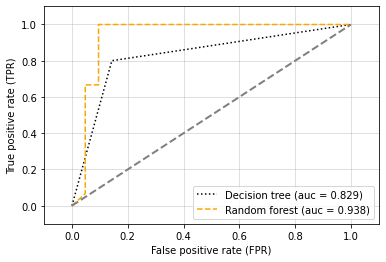

In [ ]:
colors = ['black', 'orange']
linestyles = [':', '--']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr)
  plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.3f)' % (label, roc_auc))
  
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
          linestyle='--',
          color='gray',
          linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

### 정오분류표로 검정

In [ ]:
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))


잘못 분류된 샘플 개수: 3
정확도: 0.917
정밀도: 0.875
재현율: 0.933
F1: 0.903


### 오답 확인

참고 <알콜 평균>
- 라벨 0  :  12.27
- 라벨 1  :  13.15

     <희석비율 평균>
- 라벨 0 : 2.7
- 라벨 1 : 1.68

In [ ]:
test = pd.DataFrame(np.column_stack([X_test,y_test]), columns=['Alcohol', '희석한 와인 비율','label'])
test[y_test != y_pred]

Alcohol  희석한 와인 비율  label
1     12.93       2.31    1.0
22    13.05       2.01    0.0
29    13.34       1.93    0.0

## Boosting - ADABOOST

의사결정나무와 AdaBoost 기법을 이용하여 모델을 구축

In [ ]:
tree = DecisionTreeClassifier(max_depth=1, 
                              criterion='entropy',
                                random_state=1)

adaboost = AdaBoostClassifier(base_estimator=tree, 
                                n_estimators=700,
                                learning_rate = 0.01, 
                                random_state=1)

clf_labels = ['Decision tree', 'Ada boost']

all_clf = [tree, adaboost]

###  AUC 검정

의사결정나무만을 사용했을때는 AUC값이 91%인 반면, AdaBoost를 적용했을때는 AUC값이 98%로 증가했음을 알 수 있다.


In [ ]:
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
  % (scores.mean(), scores.std(), label))


ROC AUC: 0.911 (+/- 0.088) [Decision tree]
ROC AUC: 0.978 (+/- 0.033) [Ada boost]


### ROC 커브

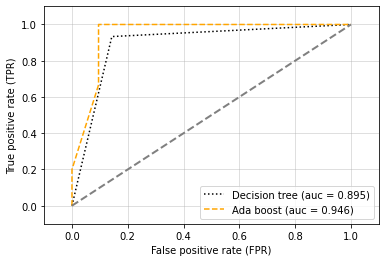

In [ ]:
colors = ['black', 'orange']
linestyles = [':', '--']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr)
  plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.3f)' % (label, roc_auc))
  
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
          linestyle='--',
          color='gray',
          linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

### 정오 분류표로 검정

In [ ]:
adaboost.fit(X_train, y_train)
y_pred = adaboost.predict(X_test)

print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 3
정확도: 0.917
정밀도: 0.875
재현율: 0.933
F1: 0.903


### 오답 확인

참고 <알콜 평균>
- 라벨 0  :  12.27
- 라벨 1  :  13.15

     <희석비율 평균>
- 라벨 0 : 2.7
- 라벨 1 : 1.68

In [ ]:
test = pd.DataFrame(np.column_stack([X_test,y_test]), columns=['Alcohol', '희석한 와인 비율','label'])
test[y_test != y_pred]

Alcohol  희석한 와인 비율  label
5     12.53       1.69    1.0
22    13.05       2.01    0.0
29    13.34       1.93    0.0

# 시각화

In [ ]:
# 결정 경계 영역을 살펴보기 위한 코드
# X축은 희석 비율, Y축은 도수, 그래프 안의 기호는 와인 클래스에 해당
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
 np.arange(y_min, y_max, 0.1))
# 2차원 평면에 x,y Grid를 생성
#print(xx)


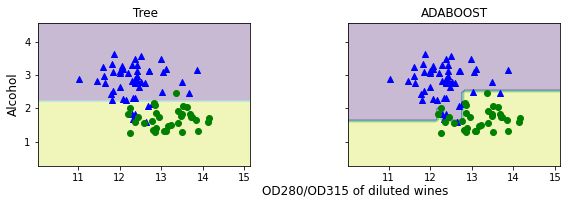

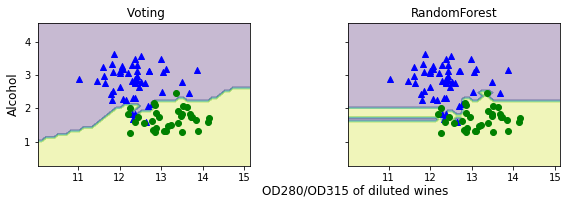

In [ ]:
  f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))
  for idx, clf, tt in zip([0, 1],[tree, adaboost],[' Tree','ADABOOST']):
      clf.fit(X_train, y_train)
      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # 위에서의 다차원 배열을 1차원으로 변환한 후(ravel), column기준 세로로 붙여 2차원 배열 생성
    # 데이터 셋에 대해 예측

      Z = Z.reshape(xx.shape) # 예측값을 다시 2차원 형태로 변환 (그래프 적용 위함)
      axarr[idx].contourf(xx, yy, Z, alpha=0.3) # 등고선 그리는 함수 중 하나
      axarr[idx].scatter(X_train[y_train == 0, 0],
      X_train[y_train == 0, 1],
      c='blue', marker='^')
      axarr[idx].scatter(X_train[y_train == 1, 0],
      X_train[y_train == 1, 1],
      c='green', marker='o')
      axarr[idx].set_title(tt)

  axarr[0].set_ylabel('Alcohol', fontsize=12)

  plt.text(10.2, -0.5,
          s='OD280/OD315 of diluted wines',
          ha='center', va='center', fontsize=12)

  plt.tight_layout()
  plt.show()
  # 단일 모델에 비해 유연한 분류 결과를 확인할 수 있음.
  f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))
  for idx, clf, tt in zip([0, 1],[voting, forest],[' Voting','RandomForest']):
      clf.fit(X_train, y_train)
      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # 위에서의 다차원 배열을 1차원으로 변환한 후(ravel), column기준 세로로 붙여 2차원 배열 생성
    # 데이터 셋에 대해 예측

      Z = Z.reshape(xx.shape) # 예측값을 다시 2차원 형태로 변환 (그래프 적용 위함)
      axarr[idx].contourf(xx, yy, Z, alpha=0.3) # 등고선 그리는 함수 중 하나
      axarr[idx].scatter(X_train[y_train == 0, 0],
      X_train[y_train == 0, 1],
      c='blue', marker='^')
      axarr[idx].scatter(X_train[y_train == 1, 0],
      X_train[y_train == 1, 1],
      c='green', marker='o')
      axarr[idx].set_title(tt)

  axarr[0].set_ylabel('Alcohol', fontsize=12)

  plt.text(10.2, -0.5,
          s='OD280/OD315 of diluted wines',
          ha='center', va='center', fontsize=12)

  plt.tight_layout()
  plt.show()
  # 단일 모델에 비해 유연한 분류 결과를 확인할 수 있음.

# AUC 다른 이유

* ROC곡선은 분류 결정 임계값에 따라 FPR이 변할때 TPR이 어떻게 변하는지를 나타내는 곡선. 
* AUC =  ROC 곡선 면적. 최적 모형 AUC = 1 (정사각형)

$TPR = TP / (FN + TP)$   민감도

$FPR = FP / (FP + TN ) = 1- TNR = 1- ( TN / FP + TN)$   1-특이도

##### roc_curve() 

* 입력값 : 1)실제 클래스 값 array , 2) predict_prob()의 반환값 array에서 양성 클래스 예측 확률
* 반환값 :  1)FPR, 2)TPR, 3) 임계값을 담은 넘파이 ndarray

AUC가 다른 이유를 알아보기위해 사이킷런이 제공하는 roc_curve() API를 사용하여 FPR ,TPR, 임계값들을 프린트해보기로한다.

### voting 

In [ ]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = voting.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 8건
thr_index = np.arange(0, thresholds.shape[0], 1)
print( '반환된 임곗값 배열 로우 : ', thresholds.shape[0])
print('샘플 추출을 위한 임곗값 배열의 index 8개:', thr_index)
print('샘플용 8개의 임곗값: ', np.round(thresholds[thr_index], 1))

# 1 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 1))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 1))

반환된 임곗값 배열 로우 :  8
샘플 추출을 위한 임곗값 배열의 index 8개: [0 1 2 3 4 5 6 7]
샘플용 8개의 임곗값:  [1.9 0.9 0.9 0.9 0.9 0.8 0.4 0. ]
샘플 임곗값별 FPR:  [0.  0.  0.  0.  0.  0.1 0.1 1. ]
샘플 임곗값별 TPR:  [0.  0.1 0.9 0.9 0.9 0.9 1.  1. ]


### RF

In [ ]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = forest.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 13건이므로 7건만 추출하기위해 임계값을 2step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 2)
print( '반환된 임곗값 배열 로우 : ', thresholds.shape[0])
print('샘플 추출을 위한 임곗값 배열의 index 7개:', thr_index)
print('샘플용 8개의 임곗값: ', np.round(thresholds[thr_index], 1))

# 2 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 1))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 1))

반환된 임곗값 배열 로우 :  13
샘플 추출을 위한 임곗값 배열의 index 7개: [ 0  2  4  6  8 10 12]
샘플용 8개의 임곗값:  [2.  1.  0.9 0.4 0.  0.  0. ]
샘플 임곗값별 FPR:  [0.  0.  0.  0.1 0.4 0.6 1. ]
샘플 임곗값별 TPR:  [0.  0.1 0.7 1.  1.  1.  1. ]


### adaboost

In [ ]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = adaboost.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 13건이므로 7건만 추출하기위해 임계값을 2step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 2)
print( '반환된 임곗값 배열 로우 : ', thresholds.shape[0])
print('샘플 추출을 위한 임곗값 배열의 index 7개:', thr_index)
print('샘플용 8개의 임곗값: ', np.round(thresholds[thr_index], 1))

# 2 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 1))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 1))

반환된 임곗값 배열 로우 :  13
샘플 추출을 위한 임곗값 배열의 index 7개: [ 0  2  4  6  8 10 12]
샘플용 8개의 임곗값:  [1.8 0.7 0.7 0.4 0.3 0.2 0.2]
샘플 임곗값별 FPR:  [0.  0.  0.1 0.1 0.3 0.9 1. ]
샘플 임곗값별 TPR:  [0.  0.2 0.9 1.  1.  1.  1. ]
